# Diagnosing Melanomas

###### from Udacity's Deep Learning Nanodegree

---

In this notebook, I plan to design a complete pipeline to correctly diagnose melanoma, a form of skin cancer. More specifically, this algorithm will distinguish malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).

The data and original competition stems from [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a).

Download the following sets and place these under a ```data``` folder.

- [Training data (5.3 GB)](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip).

- [Validation data (824.5 MB)](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip).

- [Test data (5.1 GB)](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip).


> **Note**: Don't forget that you need the downloaded data in the following directories: ```data/train/```, ```data/valid/``` and ```data/test/```.

## Step 1: Importing libraries

Let's import some libraries first so we have everything sorted throughout the notebook!

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os 

import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np

import scipy

import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torchvision import datasets, transforms, models

## Step 2: Visualizing data

Let's visualize a bit of the data that we're dealing with. The dataset is composed of three folders: test, train and validation. Each one has three subfolders with seborrheic keratosis, nevi and melanoma.

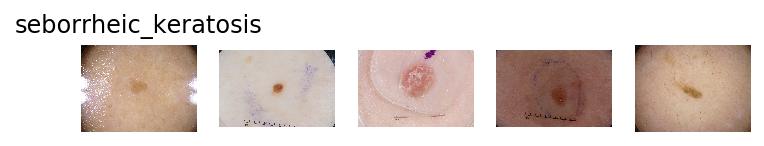

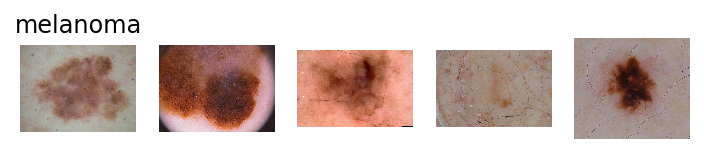

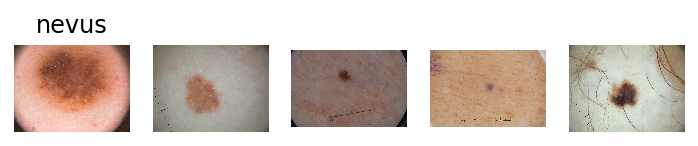

In [9]:
forms = os.listdir("data/train/")

for f in forms:
    formsPath = 'data/train/' + f 
    pics = os.listdir(formsPath)

    fig = plt.figure()
    for i in range(5):

        sp = fig.add_subplot(1, 5, i+1)
        image = imread(formsPath + '/' + pics[i])
        plt.imshow(image,cmap='Greys_r')
        plt.axis('off')
        
        if i == 0: 
            sp.set_title(f)

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


Number of faces detected: 1


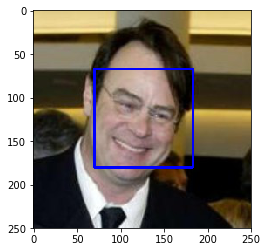

In [10]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [51]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_counter = 0
dog_counter = 0

human_files_short = human_files[: 100]
dog_files_short = dog_files[: 100]

for i in range(100):
    is_human_from_human = face_detector(human_files_short[i])
    is_human_from_dogs = face_detector(dog_files_short[i])
    
    if is_human_from_human is True:
        human_counter += 1
        
    if is_human_from_dogs is True:
        dog_counter += 1
        

In [52]:
# print integer and float value 
print("Percentage of humans on humans: {}%".format(human_counter * 100 / human_files_short.shape[0]))
print("Percentage of humans on dogs: {}%".format(dog_counter * 100 / dog_files_short.shape[0]))

Percentage of humans on humans: 98.0%
Percentage of humans on dogs: 17.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [53]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [20]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 96863156.28it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [6]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Open image 
    image = Image.open(img_path)
    
    # Declaring transforms and normalizing according to the documentation
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),        
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    
    # Applyign transforms to image and adding new dimension (needed to feed the network)
    image_tensor = transform(image).unsqueeze(0)
    
    # move the input and model to GPU for speed if available
    if use_cuda:
        image_tensor = image_tensor.to('cuda')
        
        
    # Now it's time to get the prediction! 
    # We are going to turn evaluation mode on before predicting and resume the training mode afterwards

    VGG16.eval()
    
    # Get prediction
    with torch.no_grad():
        output = VGG16(image_tensor)
        pred = torch.argmax(output).item()  # Returns the indices of the maximum value
        
    VGG16.train()
    
    return pred # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):

    prediction_index = VGG16_predict(img_path)
    
    return True if (prediction_index < 268 and prediction_index > 151) else False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [57]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

iterations = human_files_short.shape[0]

human_counter = 0
dog_counter = 0

human_files_short = human_files[: 100]
dog_files_short = dog_files[: 100]


for i in range(iterations):
    
    if dog_detector(human_files_short[i]):
        human_counter += 1
        
    if dog_detector(dog_files_short[i]):
        dog_counter += 1
    

In [58]:
print("Percentage of dogs detected on humans: {}%".format(human_counter * 100 / human_files_short.shape[0]))
print("Percentage of dogs detectedon dogs: {}%".format(dog_counter * 100 / dog_files_short.shape[0]))

Percentage of dogs detected on humans: 0.0%
Percentage of dogs detectedon dogs: 100.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [59]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

In [60]:
ResNet18 = models.resnet18(pretrained=True)

# move model to GPU 
if use_cuda:
    ResNet18 = ResNet18.cuda()

In [61]:
def ResNet18_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    # Open image 
    image = Image.open(img_path)
    
    # Declaring transforms and normalizing according to the documentation
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),        
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    
    # Applyign transforms to image and adding new dimension (needed to feed the network)
    image_tensor = transform(image).unsqueeze(0)
    
    # move the input and model to GPU for speed if available
    if use_cuda:
        image_tensor = image_tensor.to('cuda')
        
        
    # Now it's time to get the prediction! 
    # We are going to turn evaluation mode on before predicting and resume the training mode afterwards

    ResNet18.eval()
    
    # Get prediction
    with torch.no_grad():
        output = ResNet18(image_tensor)
        pred = torch.argmax(output).item()  # Returns the indices of the maximum value
        
    ResNet18.train()
    
    return pred # predicted class index

In [62]:
### returns "True" if a dog is detected in the image stored at img_path
### we can use the same as the previous one because ResNet18 was also trained in ImageNet
def dog_detector_resnet(img_path):

    prediction_index = ResNet18_predict(img_path)
    
    return True if (prediction_index < 268 and prediction_index > 151) else False

In [63]:
iterations = human_files_short.shape[0]

human_counter = 0
dog_counter = 0

human_files_short = human_files[: 100]
dog_files_short = dog_files[: 100]


for i in range(iterations):
    
    if dog_detector_resnet(human_files_short[i]):
        human_counter += 1
        
    if dog_detector_resnet(dog_files_short[i]):
        dog_counter += 1
    

In [64]:
print("Percentage of dogs detected on humans: {}%".format(human_counter * 100 / human_files_short.shape[0]))
print("Percentage of dogs detectedon dogs: {}%".format(dog_counter * 100 / dog_files_short.shape[0]))

Percentage of dogs detected on humans: 0.0%
Percentage of dogs detectedon dogs: 99.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [64]:
import os
from torchvision import datasets

# Adding this because it fails to train when opening big images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

batch_size = 64

# defining transforms for data augmentation
train_transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean, std = std)])

validation_test_transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean, std = std)])


# defining training, validation and testing data with transformations
training_data =  datasets.ImageFolder('/data/dog_images/train', transform = train_transform)
validation_data =  datasets.ImageFolder('/data/dog_images/valid', transform = validation_test_transform)
testing_data =  datasets.ImageFolder('/data/dog_images/test', transform = validation_test_transform)



# prepare data loaders 
train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, 
                                           shuffle = True)

validation_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size,
                                          shuffle = False)

testing_loader = torch.utils.data.DataLoader(testing_data, batch_size = batch_size,
                                         shuffle = False)

# adding this because it is needed afterwards
loaders_scratch = {
    'train': train_loader,
    'valid': validation_loader,
    'test': testing_loader
}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: The previous piece of code resizes the image to a width and height of 256 and center crops it. This is applied too all data loads (training, testing and validation). The training loader has a data augmentation technique that randomizes horizontal flips and rotations. This is to better generalize and allow the CNN to train better, regardless of the translation or position of features within the picture. This is not present in the validation and testing transformations, though. We've chosen a size of 256 because it is small enough to speed up the training process but also big enough to retain the features without these significantly. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   #256x256x3 image tensor
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)   #128x128x16 image tensor
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)    #64x64x32 image tensor
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)    #32x32x64 image tensor
                                                            #16x16x128 image tensor
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512)         # we're multiplying the image tensor dimensions, the output of the feature part
        self.fc2 = nn.Linear(512, 133)         # there are 133 breed classes
        
        
        self.dropout = nn.Dropout(p = 0.3)
        self.softmax = nn.LogSoftmax(dim = 1)
            
        
    def forward(self, x):
        ## Define forward behavior

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        # flatten
        x = x.view(-1, 16 * 16 * 128)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.softmax(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ The architecture of the CNN follows four convolutional layers with maxpooling, followed by two fully connected layers. For all of these layrs, we're using a ReLU activation function. We are also using a kernel size of 3 and a padding of 1 to preserve the image in each conv layer.

This high amount of layers was to best detect features on each dogs and differenciate between cases where breeds are highly similar. 

The way the tensor changes throughout the CNN is commented on the code before.

The output of the model is with a logsoftmax, hence why we're using an NLLoss in the criterion.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [66]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.NLLLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [20]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
            
            valid_loss_min = valid_loss
            
    # return trained model
    return model


In [80]:
# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.886519 	Validation Loss: 4.885730
Validation loss decreased (inf --> 4.885730).  Saving model ...
Epoch: 2 	Training Loss: 4.883314 	Validation Loss: 4.878034
Validation loss decreased (4.885730 --> 4.878034).  Saving model ...
Epoch: 3 	Training Loss: 4.862649 	Validation Loss: 4.849324
Validation loss decreased (4.878034 --> 4.849324).  Saving model ...
Epoch: 4 	Training Loss: 4.829925 	Validation Loss: 4.809656
Validation loss decreased (4.849324 --> 4.809656).  Saving model ...
Epoch: 5 	Training Loss: 4.812593 	Validation Loss: 4.815711
Epoch: 6 	Training Loss: 4.785582 	Validation Loss: 4.772746
Validation loss decreased (4.809656 --> 4.772746).  Saving model ...
Epoch: 7 	Training Loss: 4.764438 	Validation Loss: 4.795053
Epoch: 8 	Training Loss: 4.748227 	Validation Loss: 4.745579
Validation loss decreased (4.772746 --> 4.745579).  Saving model ...
Epoch: 9 	Training Loss: 4.726908 	Validation Loss: 4.708860
Validation loss decreased (4.745579 --> 4.

In [67]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [23]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.243021


Test Accuracy: 10% (90/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [13]:
## TODO: Specify data loaders
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms

# Adding this because it fails to train when opening big images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

batch_size = 64

# defining transforms for data augmentation
train_transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean, std = std)])

validation_test_transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean, std = std)])


# defining training, validation and testing data with transformations
training_data =  datasets.ImageFolder('/data/dog_images/train', transform = train_transform)
validation_data =  datasets.ImageFolder('/data/dog_images/valid', transform = validation_test_transform)
testing_data =  datasets.ImageFolder('/data/dog_images/test', transform = validation_test_transform)



# prepare data loaders 
train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, 
                                           shuffle = True)

validation_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size,
                                          shuffle = False)

testing_loader = torch.utils.data.DataLoader(testing_data, batch_size = batch_size,
                                         shuffle = False)

# adding this because it is needed afterwards
loaders_transfer = {
    'train': train_loader,
    'valid': validation_loader,
    'test': testing_loader
}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [14]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet18(pretrained = True)

# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False
    
# Define new classifier
classifier = nn.Sequential(nn.Linear(2048, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(256, 133),
                                 nn.LogSoftmax(dim=1))

model_transfer.fc = classifier

# check if CUDA is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 78876650.53it/s]


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ The ResNet architecture did pretty well with image classifications problems. The way the ResNet is different from other models is through a technique called "identity shortcute connection", which bypasses some of the layers that ResNet has. ResNet, of course, has different versions with different amount of layers (ResNet18 has 18 layers). This prevents overfitting whilst the model is training. In addition to this, I've added two fully-connected layers that will act as the classifier and will output to 133 different classes of dog breeds.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [15]:
import torch.optim as optim

criterion_transfer = nn.NLLLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr = 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [27]:
import numpy as np

# train the model
model_transfer = train(5, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 3.490851 	Validation Loss: 1.853635
Validation loss decreased (inf --> 1.853635).  Saving model ...
Epoch: 2 	Training Loss: 1.718458 	Validation Loss: 1.128848
Validation loss decreased (1.853635 --> 1.128848).  Saving model ...
Epoch: 3 	Training Loss: 1.269931 	Validation Loss: 0.904376
Validation loss decreased (1.128848 --> 0.904376).  Saving model ...
Epoch: 4 	Training Loss: 1.109106 	Validation Loss: 0.793227
Validation loss decreased (0.904376 --> 0.793227).  Saving model ...
Epoch: 5 	Training Loss: 0.995692 	Validation Loss: 0.715409
Validation loss decreased (0.793227 --> 0.715409).  Saving model ...


In [28]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [29]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.698903


Test Accuracy: 77% (645/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [16]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image


# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(model, img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path)
    
    # Declaring transforms and normalizing according to the documentation
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(256),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])
    
    # discard the transparent, alpha channel and adding dimension (just as in the VGG prediction)
    image = transform(image)[:3,:,:].unsqueeze(0)
    
    model = model.to("cpu")    # changed to CPU because of it is expecting a floattensor, not a cuda.floattensor
    model.eval()
    idx = torch.argmax(model(image))
    return class_names[idx]

In [75]:
# go through the images file and predict each model
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    pred = predict_breed_transfer(model_transfer, img_path)
    print("Image {0}, has the following predicted breed: {1}".format(img_path, pred))

Image ./images/Welsh_springer_spaniel_08203.jpg, has the following predicted breed: Welsh springer spaniel
Image ./images/sample_human_output.png, has the following predicted breed: Chinese crested
Image ./images/Labrador_retriever_06457.jpg, has the following predicted breed: Labrador retriever
Image ./images/Curly-coated_retriever_03896.jpg, has the following predicted breed: Curly-coated retriever
Image ./images/sample_cnn.png, has the following predicted breed: Field spaniel
Image ./images/Brittany_02625.jpg, has the following predicted breed: Brittany
Image ./images/Labrador_retriever_06449.jpg, has the following predicted breed: Labrador retriever
Image ./images/American_water_spaniel_00648.jpg, has the following predicted breed: American water spaniel
Image ./images/sample_dog_output.png, has the following predicted breed: Great dane
Image ./images/Labrador_retriever_06455.jpg, has the following predicted breed: Chesapeake bay retriever


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [8]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt                        
%matplotlib inline      
import cv2         
from PIL import Image

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    if face_detector(img_path) > 0:
        pred = predict_breed_transfer(model_scratch, img_path)
        print("I know you are a human but if you were a dog, you resemble a {0}".format(pred))
    
    elif dog_detector(img_path) is True:
        pred = predict_breed_transfer(model_scratch, img_path)
        print("That's a dog! I wager that's a {0}".format(pred))
        
    else:
        print("Error occurred! I did not detect a dog nor an image!")


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
The model that I myself created (the CNN) has an accuracy of around 10% so, the results are below my expectations. I have inclusively tried to increase the learning rate but the model quickly diverged and the loss increased after 15 epochs. 

A way to increase the performance would be adding more convolutional layers to better detect details and features in the pictures. 

Another option would be having a more extensive dataset, with more images of each dog to improve the training of the model. Although further data augmentation could be helpful, I believe the improvement would be low (since we already employ rotation and horizontal flip).

Yet another way to increase the performance would include hyperparameter tuning. A different weight initalization could be helpful to reach a global minima. A different batch size or a different optimizer could also have a different impact on the model.

There are 6 total of my images.


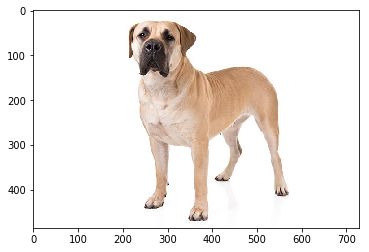

That's a dog! I wager that's a Norwegian buhund


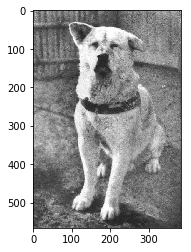

That's a dog! I wager that's a Norfolk terrier


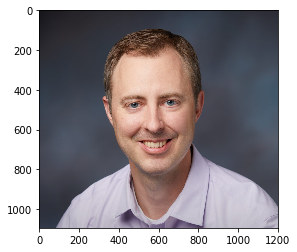

I know you are a human but if you were a dog, you resemble a Norfolk terrier


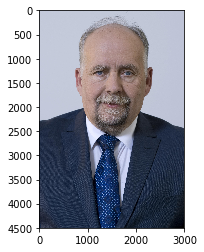

I know you are a human but if you were a dog, you resemble a English setter


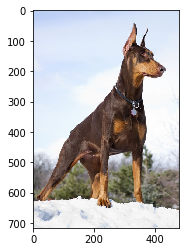

That's a dog! I wager that's a Alaskan malamute


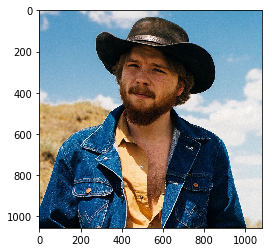

I know you are a human but if you were a dog, you resemble a English setter


In [31]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# load filenames for human and dog images
my_images_files = np.array(glob("my_images/*"))

# print number of images in each dataset
print('There are %d total of my images.' % len(my_images_files))

## suggested code, below
for file in np.hstack(my_images_files):
    run_app(file)